In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=782b5b6a4da6a378ac0800dccb4c57a918e3e5aa1db9e8d8ddc131cdcc56ec0f
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import BisectingKMeans

In [3]:
spark = SparkSession.builder.appName("Movie_recommendation").getOrCreate()

In [4]:
movies= spark.read.csv('Movies.csv', header=True, inferSchema=True)

In [5]:
tags = spark.read.csv("tags.csv", header=True, inferSchema=True)
print(list(tags.columns))

['UserID', 'MovieID', 'Tag', 'Timestamp']


In [6]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [7]:
genresIndexer = StringIndexer(inputCol="Genres", outputCol="genresIndex")
genresDF = genresIndexer.fit(movies).transform(movies)
time_scaler = StandardScaler(inputCol='Timestamp', outputCol='time_scaled')

In [8]:
tagIndexer = StringIndexer(inputCol="Tag", outputCol="tagIndex")
tagDF = tagIndexer.fit(tags).transform(tags)

In [9]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [10]:
df=genresDF.join(tagDF,"MovieID")
df.show(2)

+-------+--------------------+--------------+-----------+------+----------+----------+--------+
|MovieID|               Title|        Genres|genresIndex|UserID|       Tag| Timestamp|tagIndex|
+-------+--------------------+--------------+-----------+------+----------+----------+--------+
|   4973|Amelie (Fabuleux ...|Comedy|Romance|        4.0|    15|excellent!|1215184630|  2081.0|
|   1747|  Wag the Dog (1997)|        Comedy|        1.0|    20|  politics|1188263867|    59.0|
+-------+--------------------+--------------+-----------+------+----------+----------+--------+
only showing top 2 rows



In [11]:
from pyspark.sql.functions import col
joinedDF = df.withColumn("float_time", col("Timestamp").cast("float"))

In [12]:
assembler = VectorAssembler(inputCols=['genresIndex', 'tagIndex', 'float_time'], outputCol='features')

In [13]:
vectors=assembler.setHandleInvalid("skip").transform(joinedDF)

In [14]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

In [15]:
lsh = BucketedRandomProjectionLSH(inputCol='features', outputCol='hashes', bucketLength=2.0, numHashTables=3)
model = lsh.fit(vectors)
similarity = model.approxSimilarityJoin(vectors, vectors, threshold=0.8, distCol='cosine_similarity')

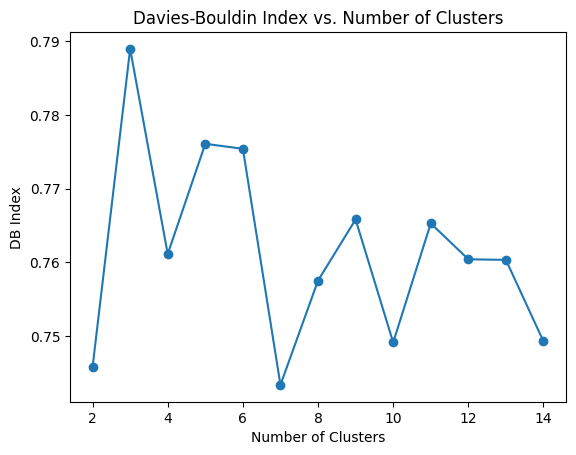

In [16]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Create the KMeans model
kmeans = KMeans(featuresCol="features")

# Define the range of cluster numbers to evaluate
min_clusters = 2
max_clusters = 14
cluster_range = range(min_clusters, max_clusters + 1)

# Initialize lists to store the cluster numbers and DBI values
cluster_numbers = []
dbi_values = []

# Perform clustering and calculate DBI for each cluster number
for num_clusters in cluster_range:
    # Set the number of clusters for the KMeans model
    kmeans.setK(num_clusters)

    # Fit the model on the data
    model = kmeans.fit(vectors)

    # Make predictions
    predictions = model.transform(vectors)

    # Evaluate clustering using the ClusteringEvaluator
    evaluator = ClusteringEvaluator()
    dbi = evaluator.evaluate(predictions)

    # Store the cluster number and DBI value
    cluster_numbers.append(num_clusters)
    dbi_values.append(dbi)

# Plot the DBI values against the number of clusters
plt.plot(cluster_numbers, dbi_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.show()


In [ ]:
#evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='prediction', metricName='silhouette')
#scores = []
#for k in range(2, 15):
#    kmeans = KMeans(featuresCol='features', k=k, seed=1)
 #   model = kmeans.fit(vectors)
  #  predictions = model.transform(vectors)
   # score = evaluator.evaluate(predictions)
    #scores.append(score)
#optimal_k = scores.index(min(scores)) + 2


In [ ]:
#kmeans = KMeans(featuresCol='features', k=optimal_k, seed=1)
#model = kmeans.fit(vectors)
#predictions = model.transform(vectors)
#db_index = evaluator.evaluate(predictions, {evaluator.metricName: 'silhouette'})
#print(db_index)

In [ ]:
#import matplotlib.pyplot as plt

#plt.plot(range(2, 15), scores)
#plt.xlabel('Number of clusters')
#plt.ylabel('Davies-Bouldin index')
#plt.title('DB index vs Number of clusters')
#plt.show()

In [17]:
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

In [18]:
bkm = BisectingKMeans(featuresCol='features', k=7, seed=1)
model = bkm.fit(vectors)

In [19]:
predictions = model.transform(vectors)

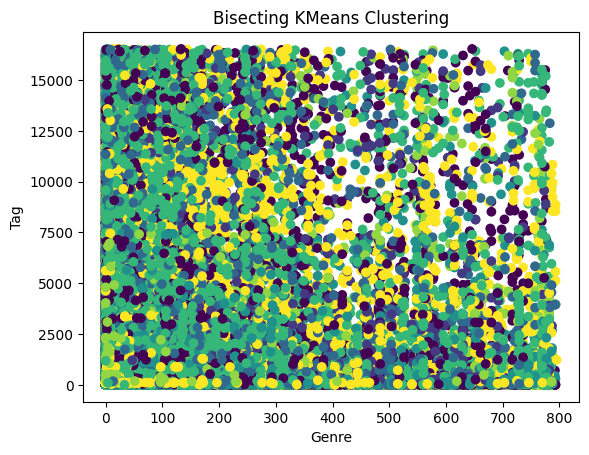

In [20]:
features = predictions.select('features').rdd.map(lambda x: x[0]).collect()
labels = predictions.select('prediction').rdd.map(lambda x: x[0]).collect()
plt.scatter([x[0] for x in features], [x[1] for x in features], c=labels)
plt.xlabel('Genre')
plt.ylabel('Tag')
plt.title('Bisecting KMeans Clustering')
plt.show()

In [21]:
predictions.show(10)

+-------+--------------------+--------------------+-----------+------+---------------+----------+--------+------------+--------------------+----------+
|MovieID|               Title|              Genres|genresIndex|UserID|            Tag| Timestamp|tagIndex|  float_time|            features|prediction|
+-------+--------------------+--------------------+-----------+------+---------------+----------+--------+------------+--------------------+----------+
|   4973|Amelie (Fabuleux ...|      Comedy|Romance|        4.0|    15|     excellent!|1215184630|  2081.0|1.21518464E9|[4.0,2081.0,1.215...|         6|
|   1747|  Wag the Dog (1997)|              Comedy|        1.0|    20|       politics|1188263867|    59.0|1.18826381E9|[1.0,59.0,1.18826...|         4|
|   1747|  Wag the Dog (1997)|              Comedy|        1.0|    20|         satire|1188263867|    98.0|1.18826381E9|[1.0,98.0,1.18826...|         4|
|   2424|You've Got Mail (...|      Comedy|Romance|        4.0|    20|chick flick 212|11

In [22]:
from pyspark.sql.functions import split, explode

# split the Genres column by "|" and explode it into multiple rows
predictions = predictions.withColumn("genre", explode(split("Genres", "\|")))

# group by the prediction and genre columns to count the frequency of each genre within each cluster
counts = predictions.groupby("prediction", "genre").count()

# use window functions to get the genre with the highest frequency within each cluster
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

window = Window.partitionBy("prediction").orderBy(counts["count"].desc())
top_genre = counts.select("*", rank().over(window).alias("rank")).filter("rank == 1")

# join the top_genre dataframe with the original dataframe to get the cluster names
cluster_names = predictions.join(top_genre, ["prediction", "genre"]).select("prediction", "genre", "count")


In [23]:
predictions.show()

+-------+--------------------+--------------------+-----------+------+---------------+----------+--------+------------+--------------------+----------+---------+
|MovieID|               Title|              Genres|genresIndex|UserID|            Tag| Timestamp|tagIndex|  float_time|            features|prediction|    genre|
+-------+--------------------+--------------------+-----------+------+---------------+----------+--------+------------+--------------------+----------+---------+
|   4973|Amelie (Fabuleux ...|      Comedy|Romance|        4.0|    15|     excellent!|1215184630|  2081.0|1.21518464E9|[4.0,2081.0,1.215...|         6|   Comedy|
|   4973|Amelie (Fabuleux ...|      Comedy|Romance|        4.0|    15|     excellent!|1215184630|  2081.0|1.21518464E9|[4.0,2081.0,1.215...|         6|  Romance|
|   1747|  Wag the Dog (1997)|              Comedy|        1.0|    20|       politics|1188263867|    59.0|1.18826381E9|[1.0,59.0,1.18826...|         4|   Comedy|
|   1747|  Wag the Dog (1997

In [24]:
from pyspark.sql.functions import desc
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import avg

In [25]:
# calculate the average timestamp for each cluster
avg_timestamp = predictions.groupBy('prediction').agg(avg('timestamp').alias('avg_timestamp'))


In [26]:
# join the average timestamp with the original dataframe
joined_df = predictions.join(avg_timestamp, on='prediction')


In [27]:
# calculate the time difference for each item
joined_df = joined_df.withColumn('time_diff', col('avg_timestamp') - col('timestamp'))


In [28]:
# calculate the average time difference for each cluster
avg_time_diff = joined_df.groupBy('prediction').agg(avg('time_diff').alias('avg_time_diff'))

# calculate the threshold value based on the average time difference
threshold = avg_time_diff.select(avg('avg_time_diff')).collect()[0][0]


In [29]:
# categorize the users into recent, medium, and old categories
from pyspark.sql.functions import when
joined_df = joined_df.withColumn('user_category',
                                  when(col('time_diff') < threshold, 'Old')
                                  .when(col('time_diff') > threshold , 'Recent')
                                  .otherwise('Medium'))


In [30]:

# define the window specification
from pyspark.sql.functions import avg, col, when, rank
from pyspark.sql.window import Window

rank_window = Window.partitionBy('prediction', 'user_category').orderBy(col('timestamp').desc())

# rank the items within each category based on the timestamp
joined_df = joined_df.withColumn('rank', rank().over(rank_window))

In [31]:
# show 10 random rows from joined_df
joined_df.show(5)

+----------+-------+-----------+--------------------+-----------+------+------+----------+--------+------------+--------------------+---------+--------------------+------------------+-------------+----+
|prediction|MovieID|      Title|              Genres|genresIndex|UserID|   Tag| Timestamp|tagIndex|  float_time|            features|    genre|       avg_timestamp|         time_diff|user_category|rank|
+----------+-------+-----------+--------------------+-----------+------+------+----------+--------+------------+--------------------+---------+--------------------+------------------+-------------+----+
|         1|  45517|Cars (2006)|Animation|Childre...|      272.0| 38875|Disney|1155786821|    15.0|1.15578688E9|[272.0,15.0,1.155...|Animation|1.1493475135365329E9|-6439307.463467121|          Old|   1|
|         1|  45517|Cars (2006)|Animation|Childre...|      272.0| 38875|Disney|1155786821|    15.0|1.15578688E9|[272.0,15.0,1.155...| Children|1.1493475135365329E9|-6439307.463467121|     

In [ ]:
#joined_df.sample(fraction=0.3).show(10)

In [32]:
rating= spark.read.csv('ratings.csv', header=True, inferSchema=True)

In [33]:
rating=rating.drop("MovieID")

In [34]:

rating.join(joined_df,"UserID")

DataFrame[UserID: int, Rating: double, TimeStamp: int, prediction: int, MovieID: int, Title: string, Genres: string, genresIndex: double, Tag: string, Timestamp: int, tagIndex: double, float_time: float, features: vector, genre: string, avg_timestamp: double, time_diff: double, user_category: string, rank: int]

In [35]:
from pyspark.sql.functions import max, when, col

# calculate the maximum rating for each user
max_rating_df = rating.groupBy('UserID').agg(max('Rating').alias('max_rating'))

# join the maximum rating with the joined_df
data_df = rating.join(max_rating_df, ['UserID'])
data_df.show(2)

+------+------+---------+----------+
|UserID|Rating|TimeStamp|max_rating|
+------+------+---------+----------+
|   148|   5.0|912681213|       5.0|
|   148|   5.0|912680580|       5.0|
+------+------+---------+----------+
only showing top 2 rows



In [36]:

rating_df = data_df.withColumn('preference_level', col('rating')/col('max_rating'))

In [37]:
# categorize the preference level into high, low, and medium
rating_df = rating_df.withColumn('preference_category',
                                 when(col('preference_level') > 0.7, 'high')
                                 .when(col('preference_level') < 0.3, 'low')
                                 .otherwise('medium'))

In [38]:
rating_df.show(10)

+------+------+---------+----------+----------------+-------------------+
|UserID|Rating|TimeStamp|max_rating|preference_level|preference_category|
+------+------+---------+----------+----------------+-------------------+
|   148|   5.0|912681213|       5.0|             1.0|               high|
|   148|   5.0|912680580|       5.0|             1.0|               high|
|   148|   4.0|912679844|       5.0|             0.8|               high|
|   148|   5.0|912680461|       5.0|             1.0|               high|
|   148|   5.0|912681212|       5.0|             1.0|               high|
|   148|   5.0|912681472|       5.0|             1.0|               high|
|   148|   4.0|912682203|       5.0|             0.8|               high|
|   148|   4.0|912681008|       5.0|             0.8|               high|
|   148|   5.0|912679648|       5.0|             1.0|               high|
|   148|   5.0|912681634|       5.0|             1.0|               high|
+------+------+---------+----------+--

In [39]:
from pyspark.sql.functions import col

In [40]:
final_df=rating_df.join(joined_df,"UserID")

In [41]:
# show 10 random rows from joined_df
final=final_df.sample(fraction=0.1)
final.show()


+------+------+----------+----------+----------------+-------------------+----------+-------+--------------------+---------------+-----------+--------------------+----------+--------+------------+--------------------+--------+--------------------+-------------------+-------------+----+
|UserID|Rating| TimeStamp|max_rating|preference_level|preference_category|prediction|MovieID|               Title|         Genres|genresIndex|                 Tag| Timestamp|tagIndex|  float_time|            features|   genre|       avg_timestamp|          time_diff|user_category|rank|
+------+------+----------+----------+----------------+-------------------+----------+-------+--------------------+---------------+-----------+--------------------+----------+--------+------------+--------------------+--------+--------------------+-------------------+-------------+----+
|    48|   5.0|1215134949|       5.0|             1.0|               high|         6|  54775|          War (2007)|Action|Thriller|       22

In [42]:
from pyspark.sql.functions import concat, col, lit

# Assuming the DataFrame is named "df"
df_concat = final.withColumn("combined_category",
                   concat(col("user_category"), lit(", "),
                          col("preference_category"), lit(", "),
                          col("genre")))

In [43]:
new_df=df_concat.select("UserID","MovieID", "Title","user_category", "preference_category", "genre","combined_category")
new_df.show(5)

+------+-------+--------------------+-------------+-------------------+--------+--------------------+
|UserID|MovieID|               Title|user_category|preference_category|   genre|   combined_category|
+------+-------+--------------------+-------------+-------------------+--------+--------------------+
|    48|  54775|          War (2007)|       Recent|               high|Thriller|Recent, high, Thr...|
|    48|  54775|          War (2007)|       Recent|             medium|Thriller|Recent, medium, T...|
|    48|  54775|          War (2007)|       Recent|               high|  Action|Recent, high, Action|
|    48|  54290|Bratz: The Movie ...|       Recent|             medium|  Comedy|Recent, medium, C...|
|    48|  54290|Bratz: The Movie ...|       Recent|               high|  Comedy|Recent, high, Comedy|
+------+-------+--------------------+-------------+-------------------+--------+--------------------+
only showing top 5 rows



In [54]:
# Split the association rules into training and testing datasets
train_ratio = 0.8
test_ratio = 1 - train_ratio
seed = 12345
train_data, test_data = new_df.randomSplit([train_ratio, test_ratio], seed=seed)

In [55]:
from pyspark.sql.functions import col, collect_set, concat_ws
from pyspark.ml.fpm import FPGrowth

# Sample a fraction of the data
fraction = 0.2
sampled_df = train_data.sample(fraction=fraction)

# Group the data by UserID and collect the combined categories in a set for each user
user_categories = sampled_df.groupBy("UserID").agg(collect_set("combined_category").alias("categories"))

# Run FPGrowth on the sampled data
fpGrowth = FPGrowth(itemsCol="categories", minSupport=0.1, minConfidence=0.5)
model = fpGrowth.fit(user_categories)
association_rules = model.associationRules

# Add aliases to the generated columns

association_rules = association_rules.withColumnRenamed("UserID", "userId")
association_rules = association_rules.withColumnRenamed("antecedent", "antecedent_itemset")
association_rules = association_rules.withColumnRenamed("consequent", "consequent_itemset")
association_rules = association_rules.withColumnRenamed("confidence", "confidence_level")

# Show the association rules
association_rules.show()

+--------------------+--------------------+------------------+------------------+-------------------+
|  antecedent_itemset|  consequent_itemset|  confidence_level|              lift|            support|
+--------------------+--------------------+------------------+------------------+-------------------+
|[Old, medium, Cri...|[Old, high, Thril...|0.8690476190476191| 2.498511904761905| 0.1983695652173913|
|[Old, medium, Cri...| [Old, high, Comedy]|0.6071428571428571| 1.816492450638792|0.13858695652173914|
|[Old, medium, Cri...|[Old, medium, Thr...|0.8571428571428571| 2.523428571428571| 0.1956521739130435|
|[Old, medium, Cri...|  [Old, high, Crime]|0.9523809523809523|3.5762876579203104|0.21739130434782608|
|[Old, medium, Cri...|[Old, medium, Com...|0.6309523809523809|2.0367585630743528|0.14402173913043478|
|[Old, medium, Cri...|[Old, medium, Drama]|0.9880952380952381| 2.272619047619048|0.22554347826086957|
|[Old, medium, Cri...|[Old, medium, Act...|0.6428571428571429|2.2530612244897963|0

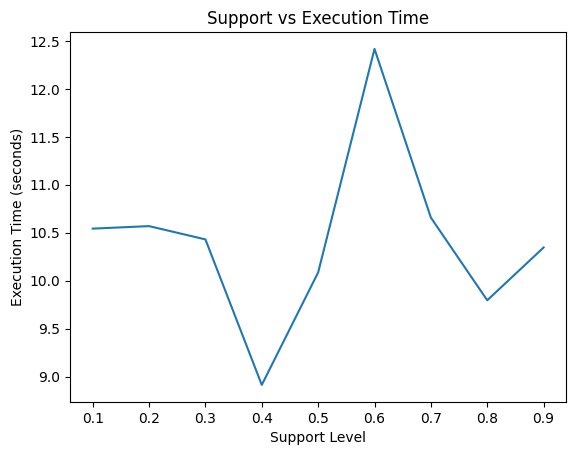

In [69]:
import matplotlib.pyplot as plt
import time

# Initialize empty lists for support and execution time
supports = []
execution_times = []

# Loop through support values and record execution time for each
for support in range(1, 10):
    support /= 10.0  # Convert to float
    start_time = time.time()
    fpGrowth = FPGrowth(itemsCol="categories", minSupport=support, minConfidence=0.5)
    model = fpGrowth.fit(user_categories)
    end_time = time.time()
    execution_time = end_time - start_time
    supports.append(support)
    execution_times.append(execution_time)

# Create a line plot
plt.plot(supports, execution_times)

# Customize plot
plt.title('Support vs Execution Time')
plt.xlabel('Support Level')
plt.ylabel('Execution Time (seconds)')

# Display plot
plt.show()


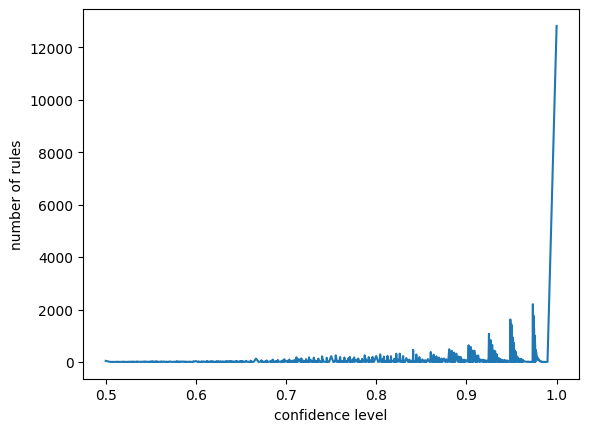

In [67]:
import matplotlib.pyplot as plt

# count the number of rules at each confidence level
num_rules_by_confidence = association_rules.groupBy("confidence_level").count().orderBy("confidence_level")

# extract the confidence levels and counts as arrays
confidences = num_rules_by_confidence.select("confidence_level").rdd.flatMap(lambda x: x).collect()
num_rules = num_rules_by_confidence.select("count").rdd.flatMap(lambda x: x).collect()

# plot the results
plt.plot(confidences, num_rules)
plt.xlabel("confidence level")
plt.ylabel("number of rules")
plt.show()


In [70]:
# Select strong association rules based on confidence level, lift value, and support count
min_confidence = 0.8
min_lift = 1.2
min_support = 0.2

strong_rules = association_rules.filter((col("confidence_level") >= min_confidence) &
                                         (col("lift") >= min_lift) &
                                         (col("support") >= min_support))

# Sort the rules by decreasing confidence level
#sorted_rules = strong_rules.sort(col("confidence_level").desc())

# Show the top 10 rules
strong_rules.show(10)

+--------------------+--------------------+------------------+------------------+-------------------+
|  antecedent_itemset|  consequent_itemset|  confidence_level|              lift|            support|
+--------------------+--------------------+------------------+------------------+-------------------+
|[Old, medium, Cri...|  [Old, high, Crime]|0.9523809523809523|3.5762876579203104|0.21739130434782608|
|[Old, medium, Cri...|[Old, medium, Drama]|0.9880952380952381| 2.272619047619048|0.22554347826086957|
|[Old, high, Romance]|  [Old, high, Drama]|              0.85|1.8399999999999999|0.23097826086956522|
|[Old, high, Romance]|[Old, medium, Rom...|              0.83|3.5108045977011493|0.22554347826086957|
|[Old, medium, Com...|[Old, medium, Drama]|0.9615384615384616|2.2115384615384617|0.20380434782608695|
|[Old, medium, Act...| [Old, high, Action]|0.9333333333333333|3.1510703363914376|  0.266304347826087|
|[Old, medium, Com...|  [Old, high, Drama]|0.9493670886075949|2.0551005212211466|0

In [71]:
# Select the top n rules based on confidence level
n = 10
# Get the top itemsets from the association rules
top_rules = association_rules.sort(col("confidence_level").desc()).limit(10)
#top_itemsets = set(top_rules.select(col("antecedent_itemset")).rdd.flatMap(lambda x: x).map(tuple).collect() + top_rules.select(col("consequent_itemset")).rdd.flatMap(lambda x: x).map(tuple).collect())
top_itemsets = set([tuple(itemset) for itemset in top_rules.select(col("antecedent_itemset")).rdd.flatMap(lambda x: x).collect() + top_rules.select(col("consequent_itemset")).rdd.flatMap(lambda x: x).collect()])


top_rules.show()
#training_data = train_data.filter(col("combined_category").isin(top_itemsets))


+--------------------+--------------------+----------------+------------------+-------------------+
|  antecedent_itemset|  consequent_itemset|confidence_level|              lift|            support|
+--------------------+--------------------+----------------+------------------+-------------------+
|[Recent, medium, ...|[Old, high, Thril...|             1.0|             2.875|0.10869565217391304|
|[Old, high, Sci-F...|[Old, high, Thril...|             1.0|             2.875|0.10326086956521739|
|[Old, medium, Sci...| [Old, high, Sci-Fi]|             1.0| 5.257142857142857|0.10054347826086957|
|[Recent, medium, ...|[Recent, high, Co...|             1.0| 3.315315315315315|0.10597826086956522|
|[Old, medium, Rom...|[Old, medium, Act...|             1.0|3.5047619047619047|0.10326086956521739|
|[Old, high, Sci-F...| [Old, high, Action]|             1.0| 3.376146788990826|0.10326086956521739|
|[Old, high, Fanta...|[Old, medium, Drama]|             1.0|2.3000000000000003|0.11956521739130435|


In [58]:
print("Top itemsets:")
for itemset in top_itemsets:
    print(itemset)


Top itemsets:
('Recent, medium, Drama', 'Old, medium, Thriller', 'Recent, high, Drama', 'Old, high, Drama')
('Old, high, Adventure', 'Old, medium, Romance', 'Old, medium, Adventure', 'Old, high, Action', 'Old, medium, Drama')
('Old, medium, Action',)
('Old, high, Action',)
('Recent, high, Crime', 'Recent, medium, Action', 'Recent, high, Action', 'Recent, medium, Comedy', 'Recent, medium, Drama')
('Old, high, Fantasy', 'Old, medium, Action', 'Old, high, Drama')
('Old, medium, Drama',)
('Recent, high, Comedy',)
('Old, medium, Sci-Fi', 'Old, medium, Action', 'Old, high, Action', 'Old, medium, Comedy', 'Old, high, Comedy', 'Old, medium, Thriller', 'Old, high, Thriller')
('Old, medium, Romance', 'Old, medium, Adventure', 'Old, high, Action', 'Old, medium, Comedy', 'Old, high, Thriller')
('Old, high, Comedy',)
('Recent, high, Drama',)
('Old, medium, Fantasy', 'Old, medium, Action', 'Old, medium, Comedy', 'Old, high, Comedy', 'Old, high, Thriller', 'Old, high, Drama')
('Old, medium, Crime', '

In [59]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import DoubleType
from pyspark.ml.classification import RandomForestClassifier


from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType, StructType, StructField, StringType

In [60]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, OneHotEncoderModel
from pyspark.sql.functions import when, col

In [61]:
def build_classifier_model(association_rules, train_data):
    # Convert the association rules into a dictionary for efficient lookup
    rules_dict = association_rules.rdd.filter(lambda x: x.confidence_level is not None).map(lambda x: ((frozenset(x.antecedent_itemset), frozenset(x.consequent_itemset)), x.confidence_level)).collectAsMap()

    # Define a UDF for extracting the antecedent features from the combined category
    extract_antecedent_udf = udf(lambda x: x[:-1])

    # Extract the antecedent features from the combined category
    train_data = train_data.withColumn("antecedent_features", extract_antecedent_udf(col("combined_category")))

    # Create a list of all the unique antecedent feature combinations
    antecedent_list = train_data.select("antecedent_features").distinct().rdd.flatMap(lambda x: x).collect()

    # Create a new DataFrame with one row for each unique antecedent feature combination
    schema = StructType([StructField("features", StringType(), True)])
    antecedent_df = spark.createDataFrame([(antecedent,) for antecedent in antecedent_list], schema=schema)

    # Define a StringIndexer to convert the antecedent features to numeric values
    indexer = StringIndexer(inputCol="features", outputCol="indexed_features")

    # Fit the indexer on the antecedent features
    antecedent_indexer_model = indexer.fit(antecedent_df)

    # Define a OneHotEncoder to convert the indexed features to binary vectors
    antecedent_encoder = OneHotEncoder(inputCols=["indexed_features"], outputCols=["antecedent_vector"])

    # Fit the encoder on the indexed features
    antecedent_encoder_model = antecedent_encoder.fit(antecedent_indexer_model.transform(antecedent_df))

    # Use the fitted encoder to transform the indexed features
    antecedent_encoded = antecedent_encoder_model.transform(antecedent_indexer_model.transform(antecedent_df))

     # Join the encoded antecedent features with the training data
    train_data = train_data.join(antecedent_encoded, train_data.antecedent_features == antecedent_encoded.features, "left").drop("features")
    train_data = train_data.join(final, ["UserID", "MovieID"], "left_outer").fillna(0)

    # Make a prediction for each antecedent feature combination using the association rules
    predict_udf = udf(lambda x: max([rules_dict.get((frozenset(antecedent.split(",")), frozenset(x.split(","))), 0.0) for antecedent in antecedent_list]), DoubleType())
    train_data = train_data.withColumn("predicted_confidence", predict_udf(col("antecedent_features")))

    # Convert the predicted confidence to a vector
    assembler = VectorAssembler(inputCols=["predicted_confidence"], outputCol="features_1")
    train_data = assembler.transform(train_data)
    # Define the target variable
    target_col = "has_rated_movie"
    # Create a new column that contains the class labels
    train_data = train_data.withColumn(target_col, when(col("rating") > 0, 1).otherwise(0))
    print(train_data)

    return model, antecedent_list


In [62]:
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import array
import pyspark
from pyspark.sql import SparkSession

In [63]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("sample").getOrCreate()

In [64]:
model, antecedent_list = build_classifier_model(association_rules, train_data)

DataFrame[UserID: int, MovieID: int, Title: string, user_category: string, preference_category: string, genre: string, combined_category: string, antecedent_features: string, indexed_features: double, antecedent_vector: vector, Rating: double, TimeStamp: int, max_rating: double, preference_level: double, preference_category: string, prediction: int, Title: string, Genres: string, genresIndex: double, Tag: string, Timestamp: int, tagIndex: double, float_time: float, features: vector, genre: string, avg_timestamp: double, time_diff: double, user_category: string, rank: int, predicted_confidence: double, features_1: vector, has_rated_movie: int]


In [65]:
def test_classifier_model(model, association_rules, test_data, n_recommendations, antecedent_list):
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import udf, col
    from pyspark.sql.types import DoubleType, ArrayType

    try:
        # Try to get an existing SparkSession object
        spark = SparkSession.builder.appName("test_classifier_model2").getOrCreate()
    except:
        # If no existing SparkSession object is found, create a new one
        spark = SparkSession.builder.appName("test_classifier_model2").getOrCreate()

    rules_dict = association_rules.rdd.map(lambda x: ((tuple(x.antecedent_itemset), tuple(x.consequent_itemset)), x.confidence_level)).collectAsMap()
    extract_antecedent_udf = udf(lambda x: x[:-1])
    test_data = test_data.withColumn("antecedent_features", extract_antecedent_udf(col("combined_category")))
    predict_udf = udf(lambda x: [rules_dict.get((frozenset(antecedent.split(",")), frozenset(x.split(","))), 0.0) for antecedent in antecedent_list], ArrayType(DoubleType()))
    predictions = test_data.withColumn("probability", predict_udf(col("antecedent_features")))
    sorted_predictions = predictions.orderBy(col("probability").desc())

    return sorted_predictions

n_recommendations = 10
result = test_classifier_model(model, association_rules, test_data, n_recommendations, antecedent_list)
print(result)
result = result.drop(col('probability'))
result = result.drop(col('MovieID'))


result.show(10)


DataFrame[UserID: int, MovieID: int, Title: string, user_category: string, preference_category: string, genre: string, combined_category: string, antecedent_features: string, probability: array<double>]
+------+--------------------+-------------+-------------------+--------+--------------------+--------------------+
|UserID|               Title|user_category|preference_category|   genre|   combined_category| antecedent_features|
+------+--------------------+-------------+-------------------+--------+--------------------+--------------------+
|    48|          War (2007)|       Recent|             medium|Thriller|Recent, medium, T...|Recent, medium, T...|
|    75|     Crow The (1994)|          Old|             medium|  Action| Old, medium, Action|  Old, medium, Actio|
|    78|Enemy at the Gate...|          Old|               high|   Drama|    Old, high, Drama|     Old, high, Dram|
|    75|     Crow The (1994)|          Old|             medium|   Crime|  Old, medium, Crime|   Old, medium